# MobileNetV2

In this notebook we will be implementing a modified version of [paper], a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). 

ImageNet dataset consist on a set of images (the authors used 1.28 million training images, 50k validation images and 100k test images) of size (224x224) belonging to 1000 different classes. However, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consist on a different set of images (45k training images, 5k validation images and 10k testing images) distributed into just 10 different classes. The classes are: <font color = red>airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck</font>. 

<br>
<div style="text-align: center">
    <img src="./../assets/cifar10.png" width="70%">
</div>
<br>

You can read this [website](https://towardsdatascience.com/everything-you-need-to-know-about-mobilenetv3-and-its-comparison-with-previous-versions-a5d5e5a6eeaa) to study MobileNetV2.

<div style="text-align: center">
    <img src="./assets/mobilenet3_large.png" width="100%">
</div>
<div style="text-align: center">mobilenetv3 large architecture</div>
<br>

<div style="text-align: center">
    <img src="./assets/mobilenet3_small.png" width="100%">
</div>
<div style="text-align: center">mobilenetv3 small architecture</div>
<br>

[paper]: https://arxiv.org/abs/1905.02244

### Data Processing

As always, we'll start by importing all the necessary modules. We have a few new imports here:
- `lr_scheduler` for using the one cycle learning rate scheduler
- `namedtuple` for handling ResNet configurations
- `os` and `shutil` for handling custom datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy, random, time, math

We set the random seed so all of our experiments can be reproduced.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently. 

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [4]:
ROOT = './../data'

# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 
                5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation. 

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [5]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [6]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


...create a validation set from our training set...

In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and ensure our validation set uses the test transforms.

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We print out the number of examples in each set of data to ensure everything has gone OK so far. The total num of CIFAR10 is 60000.

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of all examples: {len(train_data) + len(valid_data) + len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000
Number of all examples: 60000


We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

The final bit of the data processing is creating the iterators.

We use a much larger batch size here than in previous models. Generally, when using a GPU, a larger batch size means our model trains faster. Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer.

In [11]:
BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the Model

Next up is defining the model.

The actual model itself is no more difficult to understand than the previous model, LeNet. It is made up of convolutional layers, pooling layers and ReLU activation functions. See the previous notebook for a refresher on these concepts. 

There are only two new concepts introduced here, `nn.Sequential` and `nn.Dropout`.

We can think of `Sequential` as like our transforms introduced earlier for data augmentation. We provide `Sequential` with multiple layers and when the `Sequential` module is called it will apply each layer, in order, to the input. There is no difference between using a `Sequential` and having each module defined in the `__init__` and then called in `forward` - however it makes the code significantly shorter.

We have one `Sequential` model, `features`, for all the convolutional and pooling layers, then we flatten then data and pass it to the `classifier`, another `Sequential` model which is made up of linear layers and the second new concept, *dropout*.

Dropout is a form of [*regularization*](https://en.wikipedia.org/wiki/Regularization_(mathematics)). As our models get larger, to perform more accurately on richer datasets, they start having a significantly higher number of parameters. The problem with lots of parameters is that our models begin to *overfit*. That is, they do not learn general image features whilst learning to classify images but instead simply memorize images within the training set. This is bad as it will cause our model to achieve poor performance on the validation/testing set. To solve this overfitting problem, we use regularization. Dropout is just one method of regularization, other common ones are *L1 regularization*, *L2 regularization* and *weight decay*.

Dropout works by randomly setting a certain fraction, 0.5 here, of the neurons in a layer to zero. This effectively adds noise to the training of the neural network and causes neurons to learn with "less" data as they are only getting half of the information from a previous layer with dropout applied. It can also be thought of as causing your model to learn multiple smaller models with less parameters. 

Dropout is only applied when the model is training. It needs to be "turned off" when validating, testing or using the model for inference.

As mentioned in the previous notebook, during the convolutional and pooling layers the activation function should be placed **after** the pooling layer to reduce computational cost.

In the linear layers, dropout should be applied **after** the activation function. Although when using ReLU activation functions the same result is achieved if dropout is before or after, see [here](https://sebastianraschka.com/faq/docs/dropout-activation.html).

One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels (red, green and blue) instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.

Next up, we'll initialize the parameters of our model.

PyTorch's default initialization is usually fine however by manually trying different initialization schemes we can usually squeeze out a slight performance improvement.

We initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the `nn.init` methods to actually initialize the parameters.

For our convolutional layers, we'll initialize the weights from a Normal distribution with a standard deviation given by:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

The value of $\text{gain}$ depends on the non-linearity we will be using after the convolutional layer and we simply tell the initialization function that we are using ReLU which sets the gain to $\sqrt{2}$. The fan mode can be either `fan_in` or `fan_out`. `fan_in` is the number of connections coming into the layer and `fan_out` is the number of connections going out of the layer. For the first convolutional layer the input is from 3x3x3 filter, so the `fan_in` is 27 and the output is 64x3x3,  so the `fan_out` is 576. We leave it to the default `fan_in` mode. This initialization scheme is called *Kaiming Normal*, also known as *He Normal*. See the [paper](https://arxiv.org/abs/1502.01852) to learn more about how it was devised.

For the linear layers we initialize with a Normal distribution but this time the standard deviation is given by:

$$\text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}$$

Confusingly, instead of just telling the initialization function which non-linearity we want to use and have it calculate the gain for us, we have to tell it what gain we want to use. Luckily, `nn.init` has a `calculate_gain` function which does that for us, and we just tell it we are using ReLUs. This type of initialize scheme is called *Xavier Normal*, also known as *Glorot Normal*. See the [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for the theory behind it. 

For both types of layer we initialize the bias terms to zeros.

Why do we even need to initialize our parameters this way? See [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79) article for a great explanation, but the gist of it is that just like how we normalized our input data to have a mean of 0 and a standard deviation of 1, we also want the outputs of each activation function (and therefore the inputs to the subsequent layer) to also have a mean of 0 and a standard deviation of 1. These initialization schemes, by taking account the number of connections in to and out of a layer as well as the non-linearity used, help achieve this normalization effect when initializing weights.

In [12]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=1000, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}
        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        h = x.view(x.size(0), -1)
        x = self.classifier(h)
        return (x, h)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

We'll create an instance of our model with the desired amount of classes.

In [13]:
OUTPUT_DIM = 10

model = mobilenetv3_large(num_classes=OUTPUT_DIM)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): h_swish(
        (sigmoid): h_sigmoid(
          (relu): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Identity()
        (4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e

Then we'll see how many trainable parameters our model has. 

Our LeNet architecture had ~44k, but here we have 6.2M parameters - and GooLeNet is a relatively small model for computer vision.

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,214,842 trainable parameters


## Training the Model

Next up is the learning rate finder. The code here is taken from a stripped down and slightly modified version of the excellent [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 

**Note**: the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us 100% accuracy - but it is usually going to be better than just picking a learning rate out of thin air.  

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate. 

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated. 

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.

In [15]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):
            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):
        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [16]:
print( torch.cuda.is_available() )

True


In [17]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test` with the training iterator, the maximum learning rate and the number of iterations we want to use. 

In [18]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we can plot the learning rate against the loss. 

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [19]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before reaching a minimum and starting to increase. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

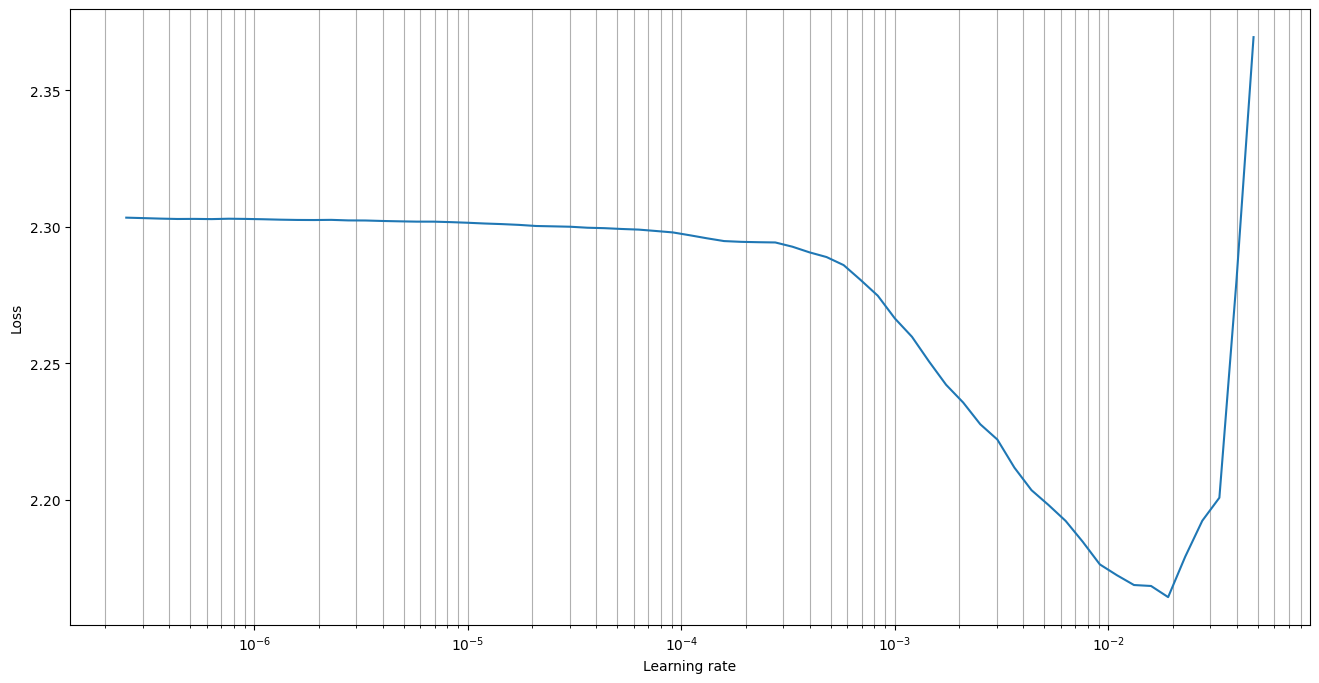

In [20]:
plot_lr_finder(lrs, losses)

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [21]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [22]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [23]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    top3_train_accuracy = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        ps = torch.exp(y_pred)
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = y.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    return (epoch_loss/len(iterator)), (epoch_acc/len(iterator)), (top3_train_accuracy/len(iterator))

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [24]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    top3_test_accuracy = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            ps = torch.exp(y_pred)
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = y.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
    return (epoch_loss/len(iterator)), (epoch_acc/len(iterator)), (top3_test_accuracy/len(iterator))

Next, we define a function to tell us how long an epoch takes.

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

Then, finally, we train our model.

We get a best validation loss of ~88% accuracy.

In [26]:
EPOCHS = 100
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy', 
                                      'Test loss', 'Test accuracy', 'Test top-3 accuracy'])

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss, train_acc, top3_train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, top3_valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mobilenetV3_cifar10-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    time_elapsed = end_time - start_time

    df = pd.DataFrame.from_dict(
                [ {'Epoch': epoch, 'Time per epoch':time_elapsed, 
                  'Avg time per step': time_elapsed/len(train_iterator), 
                  'Train loss' : train_loss, 
                  'Train accuracy': train_acc, 
                  'Train top-3 accuracy':top3_train_acc,
                  'Test loss' : valid_loss, 
                  'Test accuracy': valid_acc, 
                  'Test top-3 accuracy':top3_valid_acc} ] )
    train_stats = pd.concat([ train_stats, df], ignore_index=True)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Top3 train Acc: {train_acc*100:.2f}%')  
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Top3 valid Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 1.856 | Train Acc: 30.40% | Top3 train Acc: 30.40%
	 Val. Loss: 1.628 |  Val. Acc: 40.38% | Top3 valid Acc: 40.38%


Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 1.544 | Train Acc: 43.24% | Top3 train Acc: 43.24%
	 Val. Loss: 1.450 |  Val. Acc: 47.27% | Top3 valid Acc: 47.27%


Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 1.418 | Train Acc: 48.03% | Top3 train Acc: 48.03%
	 Val. Loss: 1.379 |  Val. Acc: 50.10% | Top3 valid Acc: 50.10%


Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 1.333 | Train Acc: 51.69% | Top3 train Acc: 51.69%
	 Val. Loss: 1.293 |  Val. Acc: 53.47% | Top3 valid Acc: 53.47%


Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 1.262 | Train Acc: 54.49% | Top3 train Acc: 54.49%
	 Val. Loss: 1.249 |  Val. Acc: 55.27% | Top3 valid Acc: 55.27%


Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 1.188 | Train Acc: 57.50% | Top3 train Acc: 57.50%
	 Val. Loss: 1.164 |  Val. Acc: 58.76% | Top3 valid Acc: 58.76%


Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 1.137 | Train Acc: 59.45% | Top3 train Acc: 59.45%
	 Val. Loss: 1.124 |  Val. Acc: 60.26% | Top3 valid Acc: 60.26%


Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 1.101 | Train Acc: 60.63% | Top3 train Acc: 60.63%
	 Val. Loss: 1.102 |  Val. Acc: 61.03% | Top3 valid Acc: 61.03%


Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 1.055 | Train Acc: 62.36% | Top3 train Acc: 62.36%
	 Val. Loss: 1.056 |  Val. Acc: 63.51% | Top3 valid Acc: 63.51%


Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 1.014 | Train Acc: 63.78% | Top3 train Acc: 63.78%
	 Val. Loss: 1.048 |  Val. Acc: 63.26% | Top3 valid Acc: 63.26%


Epoch: 11 | Epoch Time: 0m 19s
	Train Loss: 0.988 | Train Acc: 64.56% | Top3 train Acc: 64.56%
	 Val. Loss: 1.002 |  Val. Acc: 65.19% | Top3 valid Acc: 65.19%


Epoch: 12 | Epoch Time: 0m 19s
	Train Loss: 0.954 | Train Acc: 66.08% | Top3 train Acc: 66.08%
	 Val. Loss: 0.977 |  Val. Acc: 66.10% | Top3 valid Acc: 66.10%


Epoch: 13 | Epoch Time: 0m 20s
	Train Loss: 0.927 | Train Acc: 66.97% | Top3 train Acc: 66.97%
	 Val. Loss: 0.946 |  Val. Acc: 67.04% | Top3 valid Acc: 67.04%


Epoch: 14 | Epoch Time: 0m 19s
	Train Loss: 0.895 | Train Acc: 68.38% | Top3 train Acc: 68.38%
	 Val. Loss: 0.962 |  Val. Acc: 66.55% | Top3 valid Acc: 66.55%


Epoch: 15 | Epoch Time: 0m 19s
	Train Loss: 0.871 | Train Acc: 69.02% | Top3 train Acc: 69.02%
	 Val. Loss: 0.917 |  Val. Acc: 67.86% | Top3 valid Acc: 67.86%


Epoch: 16 | Epoch Time: 0m 19s
	Train Loss: 0.851 | Train Acc: 69.87% | Top3 train Acc: 69.87%
	 Val. Loss: 0.928 |  Val. Acc: 68.69% | Top3 valid Acc: 68.69%


Epoch: 17 | Epoch Time: 0m 19s
	Train Loss: 0.828 | Train Acc: 70.76% | Top3 train Acc: 70.76%
	 Val. Loss: 0.898 |  Val. Acc: 69.58% | Top3 valid Acc: 69.58%


Epoch: 18 | Epoch Time: 0m 19s
	Train Loss: 0.805 | Train Acc: 71.39% | Top3 train Acc: 71.39%
	 Val. Loss: 0.888 |  Val. Acc: 70.25% | Top3 valid Acc: 70.25%


Epoch: 19 | Epoch Time: 0m 19s
	Train Loss: 0.809 | Train Acc: 71.49% | Top3 train Acc: 71.49%
	 Val. Loss: 0.919 |  Val. Acc: 69.19% | Top3 valid Acc: 69.19%


Epoch: 20 | Epoch Time: 0m 19s
	Train Loss: 0.789 | Train Acc: 72.12% | Top3 train Acc: 72.12%
	 Val. Loss: 0.887 |  Val. Acc: 69.73% | Top3 valid Acc: 69.73%


Epoch: 21 | Epoch Time: 0m 19s
	Train Loss: 0.758 | Train Acc: 73.18% | Top3 train Acc: 73.18%
	 Val. Loss: 0.871 |  Val. Acc: 70.36% | Top3 valid Acc: 70.36%


Epoch: 22 | Epoch Time: 0m 19s
	Train Loss: 0.738 | Train Acc: 73.78% | Top3 train Acc: 73.78%
	 Val. Loss: 0.875 |  Val. Acc: 69.92% | Top3 valid Acc: 69.92%


Epoch: 23 | Epoch Time: 0m 19s
	Train Loss: 0.723 | Train Acc: 74.35% | Top3 train Acc: 74.35%
	 Val. Loss: 0.836 |  Val. Acc: 71.29% | Top3 valid Acc: 71.29%


Epoch: 24 | Epoch Time: 0m 19s
	Train Loss: 0.708 | Train Acc: 74.71% | Top3 train Acc: 74.71%
	 Val. Loss: 0.843 |  Val. Acc: 71.20% | Top3 valid Acc: 71.20%


Epoch: 25 | Epoch Time: 0m 19s
	Train Loss: 0.695 | Train Acc: 75.49% | Top3 train Acc: 75.49%
	 Val. Loss: 0.833 |  Val. Acc: 71.90% | Top3 valid Acc: 71.90%


Epoch: 26 | Epoch Time: 0m 19s
	Train Loss: 0.674 | Train Acc: 76.31% | Top3 train Acc: 76.31%
	 Val. Loss: 0.835 |  Val. Acc: 71.72% | Top3 valid Acc: 71.72%


Epoch: 27 | Epoch Time: 0m 19s
	Train Loss: 0.668 | Train Acc: 76.25% | Top3 train Acc: 76.25%
	 Val. Loss: 0.842 |  Val. Acc: 71.55% | Top3 valid Acc: 71.55%


Epoch: 28 | Epoch Time: 0m 19s
	Train Loss: 0.653 | Train Acc: 76.71% | Top3 train Acc: 76.71%
	 Val. Loss: 0.825 |  Val. Acc: 72.48% | Top3 valid Acc: 72.48%


Epoch: 29 | Epoch Time: 0m 19s
	Train Loss: 0.634 | Train Acc: 77.20% | Top3 train Acc: 77.20%
	 Val. Loss: 0.814 |  Val. Acc: 72.88% | Top3 valid Acc: 72.88%


Epoch: 30 | Epoch Time: 0m 19s
	Train Loss: 0.626 | Train Acc: 77.65% | Top3 train Acc: 77.65%
	 Val. Loss: 0.818 |  Val. Acc: 72.91% | Top3 valid Acc: 72.91%


Epoch: 31 | Epoch Time: 0m 19s
	Train Loss: 0.609 | Train Acc: 78.19% | Top3 train Acc: 78.19%
	 Val. Loss: 0.817 |  Val. Acc: 72.61% | Top3 valid Acc: 72.61%


Epoch: 32 | Epoch Time: 0m 19s
	Train Loss: 0.601 | Train Acc: 78.71% | Top3 train Acc: 78.71%
	 Val. Loss: 0.795 |  Val. Acc: 73.02% | Top3 valid Acc: 73.02%


Epoch: 33 | Epoch Time: 0m 19s
	Train Loss: 0.575 | Train Acc: 79.24% | Top3 train Acc: 79.24%
	 Val. Loss: 0.821 |  Val. Acc: 73.02% | Top3 valid Acc: 73.02%


Epoch: 34 | Epoch Time: 0m 19s
	Train Loss: 0.577 | Train Acc: 79.28% | Top3 train Acc: 79.28%
	 Val. Loss: 0.798 |  Val. Acc: 74.06% | Top3 valid Acc: 74.06%


Epoch: 35 | Epoch Time: 0m 19s
	Train Loss: 0.559 | Train Acc: 79.94% | Top3 train Acc: 79.94%
	 Val. Loss: 0.810 |  Val. Acc: 73.32% | Top3 valid Acc: 73.32%


Epoch: 36 | Epoch Time: 0m 19s
	Train Loss: 0.547 | Train Acc: 80.55% | Top3 train Acc: 80.55%
	 Val. Loss: 0.793 |  Val. Acc: 73.25% | Top3 valid Acc: 73.25%


Epoch: 37 | Epoch Time: 0m 19s
	Train Loss: 0.540 | Train Acc: 80.52% | Top3 train Acc: 80.52%
	 Val. Loss: 0.812 |  Val. Acc: 72.84% | Top3 valid Acc: 72.84%


Epoch: 38 | Epoch Time: 0m 19s
	Train Loss: 0.524 | Train Acc: 81.24% | Top3 train Acc: 81.24%
	 Val. Loss: 0.845 |  Val. Acc: 73.52% | Top3 valid Acc: 73.52%


Epoch: 39 | Epoch Time: 0m 19s
	Train Loss: 0.521 | Train Acc: 81.18% | Top3 train Acc: 81.18%
	 Val. Loss: 0.809 |  Val. Acc: 73.97% | Top3 valid Acc: 73.97%


Epoch: 40 | Epoch Time: 0m 19s
	Train Loss: 0.502 | Train Acc: 82.13% | Top3 train Acc: 82.13%
	 Val. Loss: 0.817 |  Val. Acc: 74.03% | Top3 valid Acc: 74.03%


Epoch: 41 | Epoch Time: 0m 19s
	Train Loss: 0.492 | Train Acc: 82.17% | Top3 train Acc: 82.17%
	 Val. Loss: 0.846 |  Val. Acc: 73.69% | Top3 valid Acc: 73.69%


Epoch: 42 | Epoch Time: 0m 19s
	Train Loss: 0.488 | Train Acc: 82.63% | Top3 train Acc: 82.63%
	 Val. Loss: 0.860 |  Val. Acc: 73.24% | Top3 valid Acc: 73.24%


Epoch: 43 | Epoch Time: 0m 19s
	Train Loss: 0.478 | Train Acc: 82.87% | Top3 train Acc: 82.87%
	 Val. Loss: 0.826 |  Val. Acc: 73.61% | Top3 valid Acc: 73.61%


Epoch: 44 | Epoch Time: 0m 19s
	Train Loss: 0.526 | Train Acc: 81.33% | Top3 train Acc: 81.33%
	 Val. Loss: 0.844 |  Val. Acc: 72.62% | Top3 valid Acc: 72.62%


Epoch: 45 | Epoch Time: 0m 19s
	Train Loss: 0.463 | Train Acc: 83.41% | Top3 train Acc: 83.41%
	 Val. Loss: 0.949 |  Val. Acc: 73.31% | Top3 valid Acc: 73.31%


Epoch: 46 | Epoch Time: 0m 19s
	Train Loss: 0.558 | Train Acc: 80.51% | Top3 train Acc: 80.51%
	 Val. Loss: 0.889 |  Val. Acc: 70.90% | Top3 valid Acc: 70.90%


Epoch: 47 | Epoch Time: 0m 19s
	Train Loss: 0.557 | Train Acc: 80.27% | Top3 train Acc: 80.27%
	 Val. Loss: 0.824 |  Val. Acc: 73.59% | Top3 valid Acc: 73.59%


Epoch: 48 | Epoch Time: 0m 19s
	Train Loss: 0.471 | Train Acc: 82.99% | Top3 train Acc: 82.99%
	 Val. Loss: 0.842 |  Val. Acc: 73.74% | Top3 valid Acc: 73.74%


Epoch: 49 | Epoch Time: 0m 19s
	Train Loss: 0.440 | Train Acc: 84.17% | Top3 train Acc: 84.17%
	 Val. Loss: 0.852 |  Val. Acc: 73.71% | Top3 valid Acc: 73.71%


Epoch: 50 | Epoch Time: 0m 19s
	Train Loss: 0.417 | Train Acc: 84.84% | Top3 train Acc: 84.84%
	 Val. Loss: 0.848 |  Val. Acc: 74.39% | Top3 valid Acc: 74.39%


Epoch: 51 | Epoch Time: 0m 19s
	Train Loss: 0.409 | Train Acc: 85.20% | Top3 train Acc: 85.20%
	 Val. Loss: 0.860 |  Val. Acc: 74.02% | Top3 valid Acc: 74.02%


Epoch: 52 | Epoch Time: 0m 19s
	Train Loss: 0.395 | Train Acc: 85.66% | Top3 train Acc: 85.66%
	 Val. Loss: 0.896 |  Val. Acc: 73.83% | Top3 valid Acc: 73.83%


Epoch: 53 | Epoch Time: 0m 19s
	Train Loss: 0.387 | Train Acc: 86.09% | Top3 train Acc: 86.09%
	 Val. Loss: 0.887 |  Val. Acc: 74.09% | Top3 valid Acc: 74.09%


Epoch: 54 | Epoch Time: 0m 19s
	Train Loss: 0.378 | Train Acc: 86.37% | Top3 train Acc: 86.37%
	 Val. Loss: 0.886 |  Val. Acc: 74.09% | Top3 valid Acc: 74.09%


Epoch: 55 | Epoch Time: 0m 19s
	Train Loss: 0.364 | Train Acc: 86.73% | Top3 train Acc: 86.73%
	 Val. Loss: 0.917 |  Val. Acc: 73.99% | Top3 valid Acc: 73.99%


Epoch: 56 | Epoch Time: 0m 19s
	Train Loss: 0.354 | Train Acc: 87.20% | Top3 train Acc: 87.20%
	 Val. Loss: 0.960 |  Val. Acc: 73.30% | Top3 valid Acc: 73.30%


Epoch: 57 | Epoch Time: 0m 19s
	Train Loss: 0.350 | Train Acc: 87.37% | Top3 train Acc: 87.37%
	 Val. Loss: 0.936 |  Val. Acc: 74.08% | Top3 valid Acc: 74.08%


Epoch: 58 | Epoch Time: 0m 19s
	Train Loss: 0.343 | Train Acc: 87.46% | Top3 train Acc: 87.46%
	 Val. Loss: 0.942 |  Val. Acc: 74.16% | Top3 valid Acc: 74.16%


Epoch: 59 | Epoch Time: 0m 19s
	Train Loss: 0.333 | Train Acc: 87.88% | Top3 train Acc: 87.88%
	 Val. Loss: 0.933 |  Val. Acc: 73.52% | Top3 valid Acc: 73.52%


Epoch: 60 | Epoch Time: 0m 19s
	Train Loss: 0.333 | Train Acc: 87.94% | Top3 train Acc: 87.94%
	 Val. Loss: 0.920 |  Val. Acc: 74.26% | Top3 valid Acc: 74.26%


Epoch: 61 | Epoch Time: 0m 19s
	Train Loss: 0.316 | Train Acc: 88.61% | Top3 train Acc: 88.61%
	 Val. Loss: 0.969 |  Val. Acc: 73.66% | Top3 valid Acc: 73.66%


Epoch: 62 | Epoch Time: 0m 19s
	Train Loss: 0.314 | Train Acc: 88.65% | Top3 train Acc: 88.65%
	 Val. Loss: 0.947 |  Val. Acc: 74.47% | Top3 valid Acc: 74.47%


Epoch: 63 | Epoch Time: 0m 19s
	Train Loss: 0.302 | Train Acc: 89.10% | Top3 train Acc: 89.10%
	 Val. Loss: 0.940 |  Val. Acc: 73.69% | Top3 valid Acc: 73.69%


Epoch: 64 | Epoch Time: 0m 19s
	Train Loss: 0.299 | Train Acc: 89.22% | Top3 train Acc: 89.22%
	 Val. Loss: 0.967 |  Val. Acc: 74.18% | Top3 valid Acc: 74.18%


Epoch: 65 | Epoch Time: 0m 19s
	Train Loss: 0.292 | Train Acc: 89.47% | Top3 train Acc: 89.47%
	 Val. Loss: 0.994 |  Val. Acc: 73.61% | Top3 valid Acc: 73.61%


Epoch: 66 | Epoch Time: 0m 19s
	Train Loss: 0.283 | Train Acc: 89.71% | Top3 train Acc: 89.71%
	 Val. Loss: 1.004 |  Val. Acc: 73.79% | Top3 valid Acc: 73.79%


Epoch: 67 | Epoch Time: 0m 19s
	Train Loss: 0.282 | Train Acc: 89.69% | Top3 train Acc: 89.69%
	 Val. Loss: 1.018 |  Val. Acc: 74.36% | Top3 valid Acc: 74.36%


Epoch: 68 | Epoch Time: 0m 19s
	Train Loss: 0.271 | Train Acc: 90.10% | Top3 train Acc: 90.10%
	 Val. Loss: 1.045 |  Val. Acc: 73.58% | Top3 valid Acc: 73.58%


Epoch: 69 | Epoch Time: 0m 19s
	Train Loss: 0.268 | Train Acc: 90.43% | Top3 train Acc: 90.43%
	 Val. Loss: 0.982 |  Val. Acc: 73.72% | Top3 valid Acc: 73.72%


Epoch: 70 | Epoch Time: 0m 19s
	Train Loss: 0.251 | Train Acc: 90.81% | Top3 train Acc: 90.81%
	 Val. Loss: 1.023 |  Val. Acc: 73.78% | Top3 valid Acc: 73.78%


Epoch: 71 | Epoch Time: 0m 19s
	Train Loss: 0.257 | Train Acc: 90.79% | Top3 train Acc: 90.79%
	 Val. Loss: 1.010 |  Val. Acc: 73.22% | Top3 valid Acc: 73.22%


Epoch: 72 | Epoch Time: 0m 19s
	Train Loss: 0.249 | Train Acc: 90.97% | Top3 train Acc: 90.97%
	 Val. Loss: 1.032 |  Val. Acc: 74.42% | Top3 valid Acc: 74.42%


Epoch: 73 | Epoch Time: 0m 19s
	Train Loss: 0.243 | Train Acc: 91.07% | Top3 train Acc: 91.07%
	 Val. Loss: 1.036 |  Val. Acc: 74.17% | Top3 valid Acc: 74.17%


Epoch: 74 | Epoch Time: 0m 19s
	Train Loss: 0.245 | Train Acc: 91.15% | Top3 train Acc: 91.15%
	 Val. Loss: 1.073 |  Val. Acc: 73.10% | Top3 valid Acc: 73.10%


Epoch: 75 | Epoch Time: 0m 19s
	Train Loss: 0.232 | Train Acc: 91.63% | Top3 train Acc: 91.63%
	 Val. Loss: 1.060 |  Val. Acc: 73.55% | Top3 valid Acc: 73.55%


Epoch: 76 | Epoch Time: 0m 19s
	Train Loss: 0.234 | Train Acc: 91.59% | Top3 train Acc: 91.59%
	 Val. Loss: 1.051 |  Val. Acc: 73.76% | Top3 valid Acc: 73.76%


Epoch: 77 | Epoch Time: 0m 19s
	Train Loss: 0.221 | Train Acc: 92.07% | Top3 train Acc: 92.07%
	 Val. Loss: 1.065 |  Val. Acc: 74.16% | Top3 valid Acc: 74.16%


Epoch: 78 | Epoch Time: 0m 19s
	Train Loss: 0.249 | Train Acc: 91.08% | Top3 train Acc: 91.08%
	 Val. Loss: 1.017 |  Val. Acc: 73.71% | Top3 valid Acc: 73.71%


Epoch: 79 | Epoch Time: 0m 19s
	Train Loss: 0.222 | Train Acc: 91.92% | Top3 train Acc: 91.92%
	 Val. Loss: 1.075 |  Val. Acc: 74.30% | Top3 valid Acc: 74.30%


Epoch: 80 | Epoch Time: 0m 19s
	Train Loss: 0.220 | Train Acc: 92.08% | Top3 train Acc: 92.08%
	 Val. Loss: 1.079 |  Val. Acc: 73.74% | Top3 valid Acc: 73.74%


Epoch: 81 | Epoch Time: 0m 19s
	Train Loss: 0.215 | Train Acc: 92.23% | Top3 train Acc: 92.23%
	 Val. Loss: 1.085 |  Val. Acc: 73.73% | Top3 valid Acc: 73.73%


Epoch: 82 | Epoch Time: 0m 19s
	Train Loss: 0.204 | Train Acc: 92.74% | Top3 train Acc: 92.74%
	 Val. Loss: 1.090 |  Val. Acc: 73.88% | Top3 valid Acc: 73.88%


Epoch: 83 | Epoch Time: 0m 19s
	Train Loss: 0.729 | Train Acc: 76.17% | Top3 train Acc: 76.17%
	 Val. Loss: 0.865 |  Val. Acc: 71.56% | Top3 valid Acc: 71.56%


Epoch: 84 | Epoch Time: 0m 19s
	Train Loss: 0.442 | Train Acc: 84.19% | Top3 train Acc: 84.19%
	 Val. Loss: 0.894 |  Val. Acc: 74.20% | Top3 valid Acc: 74.20%


Epoch: 85 | Epoch Time: 0m 19s
	Train Loss: 0.308 | Train Acc: 88.92% | Top3 train Acc: 88.92%
	 Val. Loss: 0.986 |  Val. Acc: 73.87% | Top3 valid Acc: 73.87%


Epoch: 86 | Epoch Time: 0m 19s
	Train Loss: 0.265 | Train Acc: 90.30% | Top3 train Acc: 90.30%
	 Val. Loss: 1.013 |  Val. Acc: 74.31% | Top3 valid Acc: 74.31%


Epoch: 87 | Epoch Time: 0m 19s
	Train Loss: 0.231 | Train Acc: 91.78% | Top3 train Acc: 91.78%
	 Val. Loss: 1.055 |  Val. Acc: 74.21% | Top3 valid Acc: 74.21%


Epoch: 88 | Epoch Time: 0m 19s
	Train Loss: 0.215 | Train Acc: 92.15% | Top3 train Acc: 92.15%
	 Val. Loss: 1.077 |  Val. Acc: 74.97% | Top3 valid Acc: 74.97%


Epoch: 89 | Epoch Time: 0m 19s
	Train Loss: 0.201 | Train Acc: 92.91% | Top3 train Acc: 92.91%
	 Val. Loss: 1.078 |  Val. Acc: 73.78% | Top3 valid Acc: 73.78%


Epoch: 90 | Epoch Time: 0m 19s
	Train Loss: 0.187 | Train Acc: 93.25% | Top3 train Acc: 93.25%
	 Val. Loss: 1.124 |  Val. Acc: 74.27% | Top3 valid Acc: 74.27%


Epoch: 91 | Epoch Time: 0m 19s
	Train Loss: 0.176 | Train Acc: 93.65% | Top3 train Acc: 93.65%
	 Val. Loss: 1.152 |  Val. Acc: 74.31% | Top3 valid Acc: 74.31%


Epoch: 92 | Epoch Time: 0m 19s
	Train Loss: 0.173 | Train Acc: 93.81% | Top3 train Acc: 93.81%
	 Val. Loss: 1.150 |  Val. Acc: 74.66% | Top3 valid Acc: 74.66%


Epoch: 93 | Epoch Time: 0m 19s
	Train Loss: 0.167 | Train Acc: 94.04% | Top3 train Acc: 94.04%
	 Val. Loss: 1.170 |  Val. Acc: 74.66% | Top3 valid Acc: 74.66%


Epoch: 94 | Epoch Time: 0m 19s
	Train Loss: 0.170 | Train Acc: 93.89% | Top3 train Acc: 93.89%
	 Val. Loss: 1.144 |  Val. Acc: 74.41% | Top3 valid Acc: 74.41%


Epoch: 95 | Epoch Time: 0m 19s
	Train Loss: 0.160 | Train Acc: 94.27% | Top3 train Acc: 94.27%
	 Val. Loss: 1.151 |  Val. Acc: 75.06% | Top3 valid Acc: 75.06%


Epoch: 96 | Epoch Time: 0m 19s
	Train Loss: 0.162 | Train Acc: 94.21% | Top3 train Acc: 94.21%
	 Val. Loss: 1.149 |  Val. Acc: 74.07% | Top3 valid Acc: 74.07%


Epoch: 97 | Epoch Time: 0m 19s
	Train Loss: 0.161 | Train Acc: 94.18% | Top3 train Acc: 94.18%
	 Val. Loss: 1.158 |  Val. Acc: 74.57% | Top3 valid Acc: 74.57%


Epoch: 98 | Epoch Time: 0m 19s
	Train Loss: 0.153 | Train Acc: 94.54% | Top3 train Acc: 94.54%
	 Val. Loss: 1.188 |  Val. Acc: 74.53% | Top3 valid Acc: 74.53%


Epoch: 99 | Epoch Time: 0m 19s
	Train Loss: 0.144 | Train Acc: 94.77% | Top3 train Acc: 94.77%
	 Val. Loss: 1.207 |  Val. Acc: 74.45% | Top3 valid Acc: 74.45%


Epoch: 100 | Epoch Time: 0m 19s
	Train Loss: 0.257 | Train Acc: 91.07% | Top3 train Acc: 91.07%
	 Val. Loss: 1.031 |  Val. Acc: 74.95% | Top3 valid Acc: 74.95%



Free cuda memory：

In [27]:
torch.cuda.empty_cache()

Save training log to a csv file:

In [28]:
train_stats.to_csv('train_log_mobilenet_v3_cifar.csv')

### Analyze Training Log

Plot test and train accuracy and test and train loss:

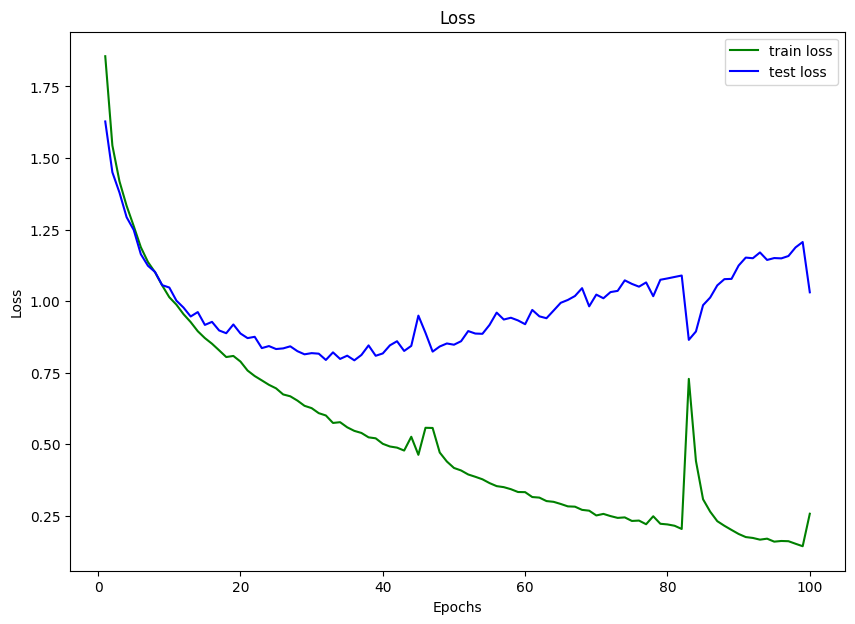

In [29]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend()

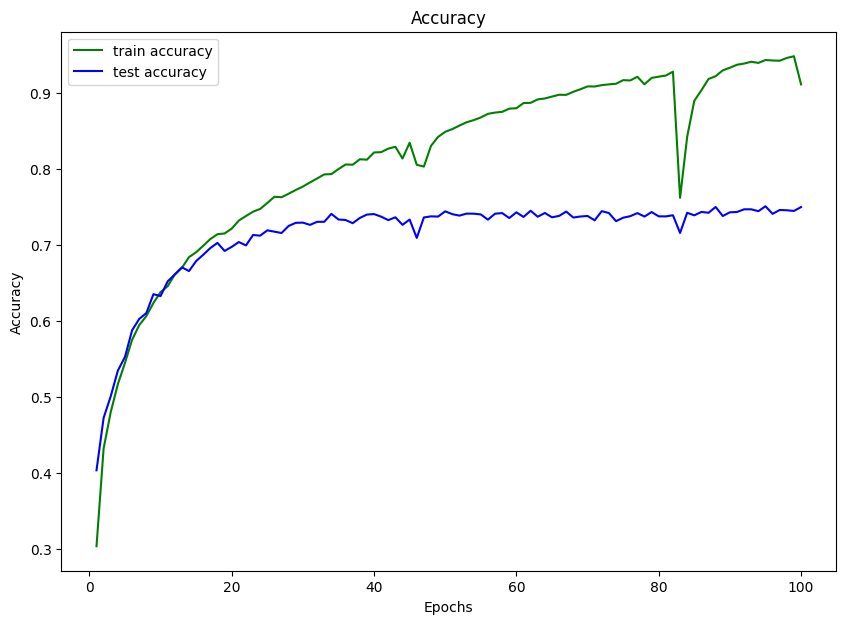

In [30]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~89% accuracy.

In [31]:
model.load_state_dict(torch.load('mobilenetV3_cifar10-model.pt'))

test_loss, test_acc, top3_test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Top3 test Acc: {top3_test_acc*100:.2f}%')
torch.cuda.empty_cache()

Test Loss: 0.811 | Test Acc: 73.11% | Top3 test Acc: 93.44%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all the predictions.

In [32]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return (images, labels, probs)

In [33]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [34]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [35]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

The two classes our model seems to get mixed up the most is cat and dog.

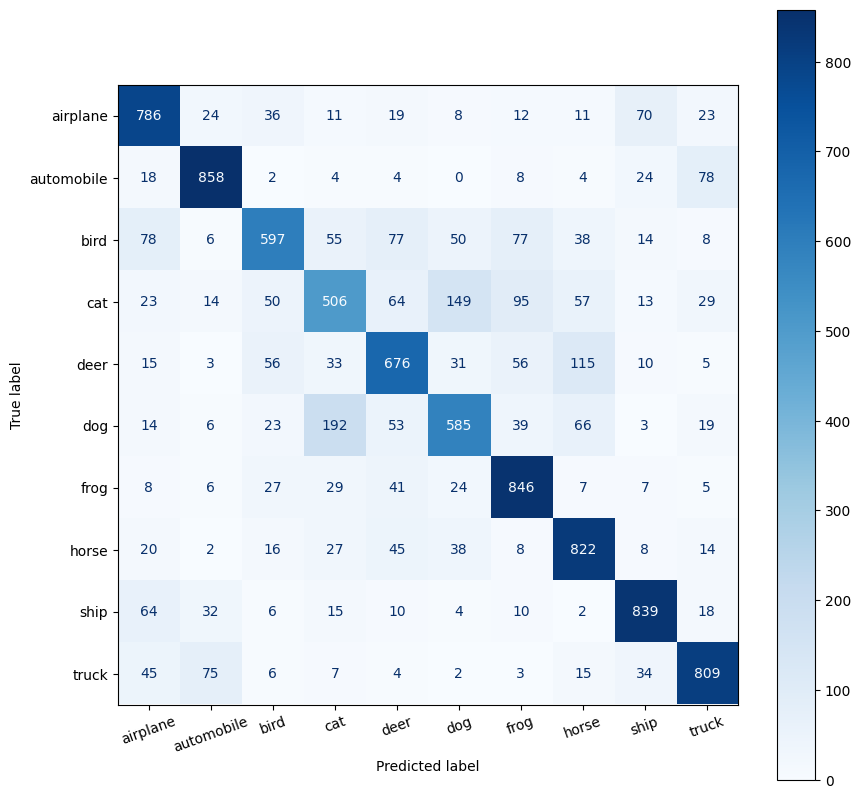

In [36]:
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [37]:
corrects = torch.eq(labels, pred_labels)

In [38]:
incorrect_examples = []

for (image, label, prob, correct) in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [39]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

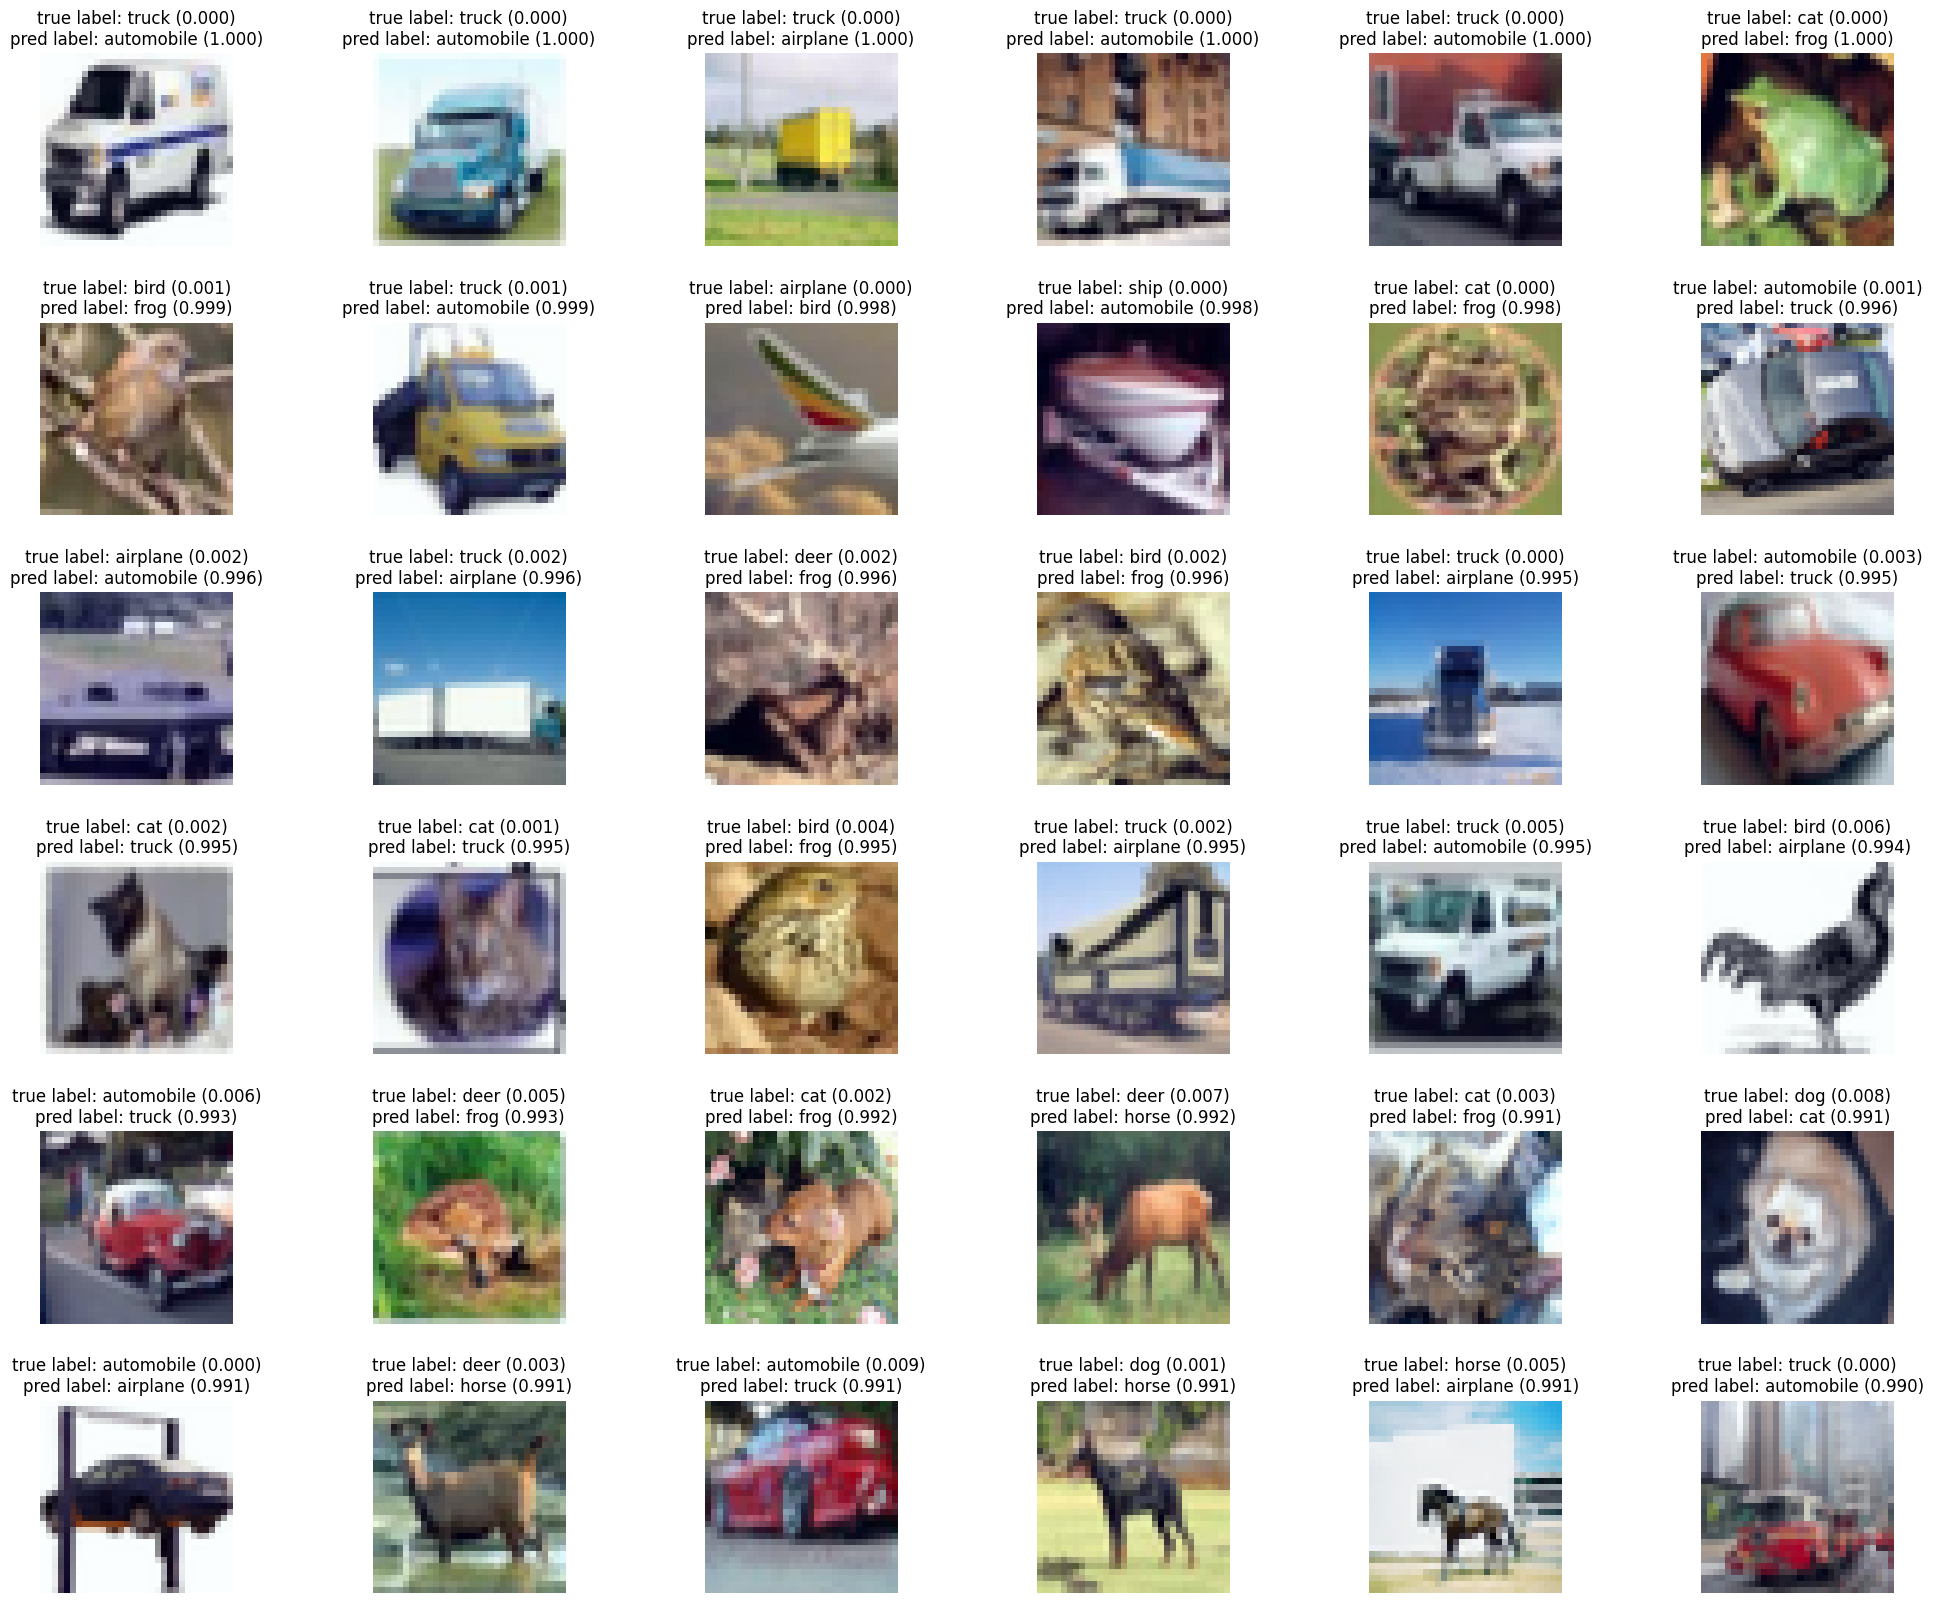

In [40]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [41]:
def get_representations(model, iterator, device):
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return (outputs, intermediates, labels)

In [42]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

We can then perform PCA on them both and plot them.

In [43]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [44]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

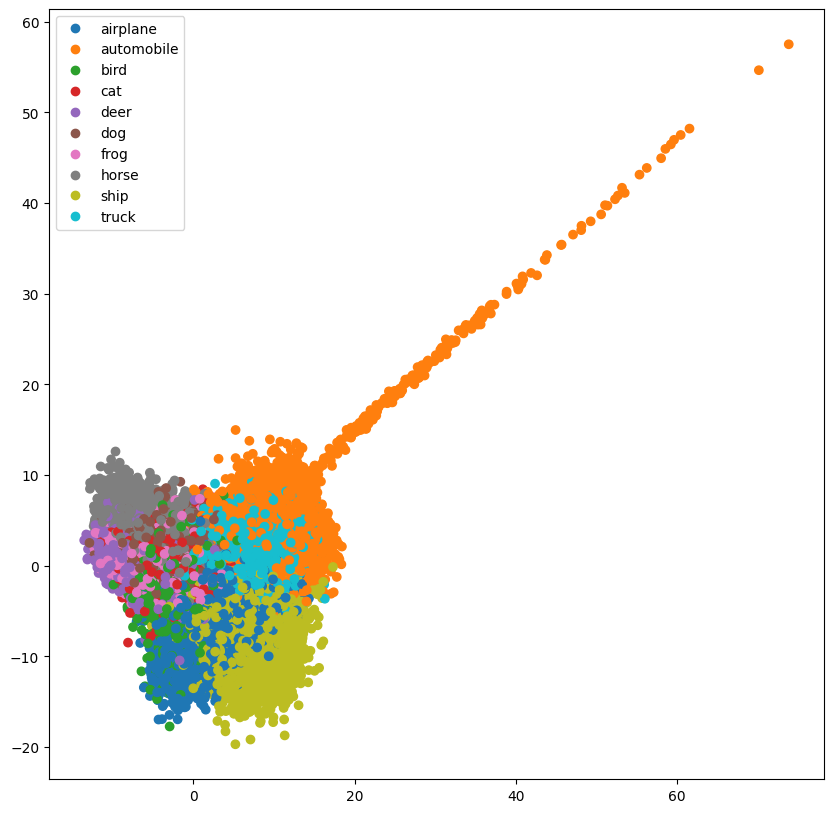

In [45]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

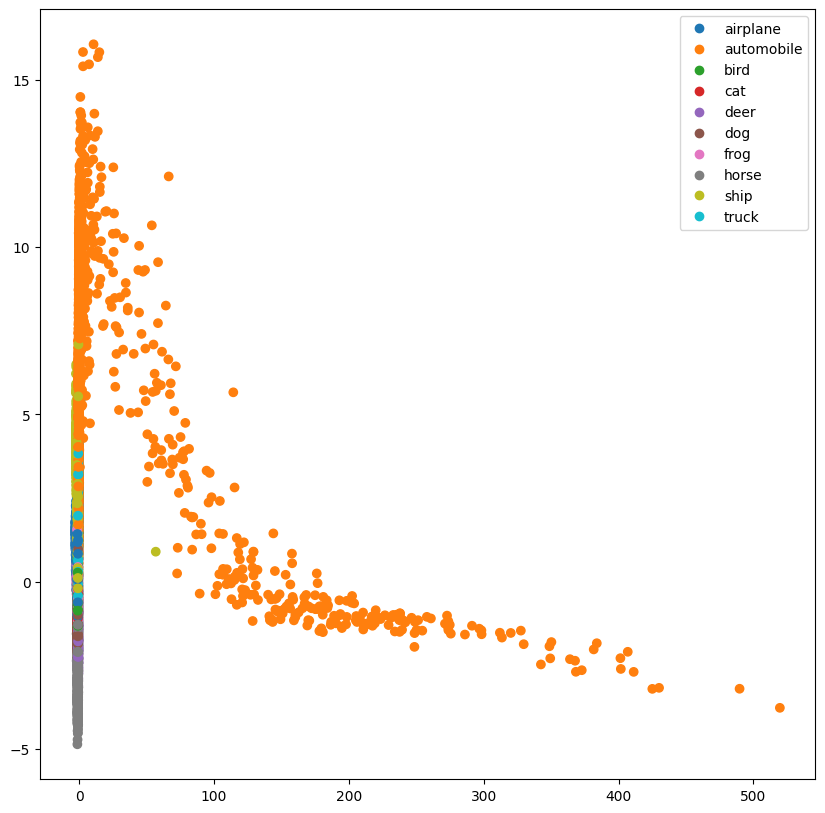

In [46]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [47]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

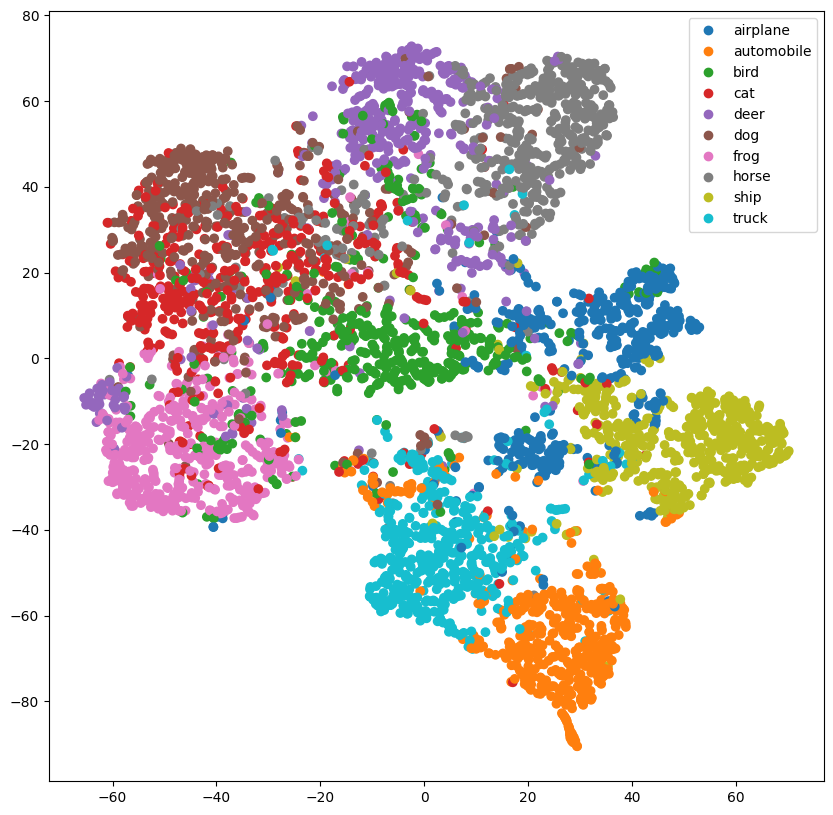

In [48]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

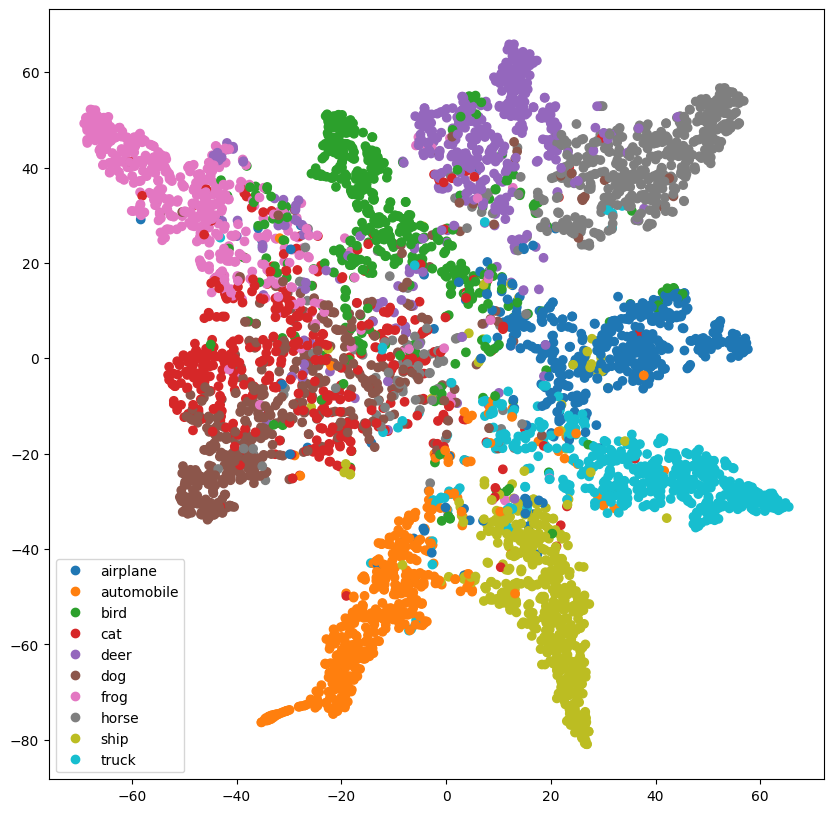

In [49]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [50]:
def imagine_image(model, classes, image, device, n_iterations=10_000):
    model.eval()

    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():
        for _ in trange(n_iterations):
            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, label], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [51]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [52]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 99.55%


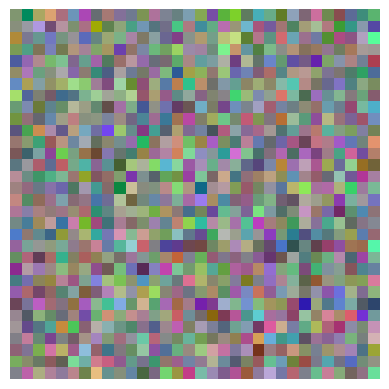

In [53]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [54]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

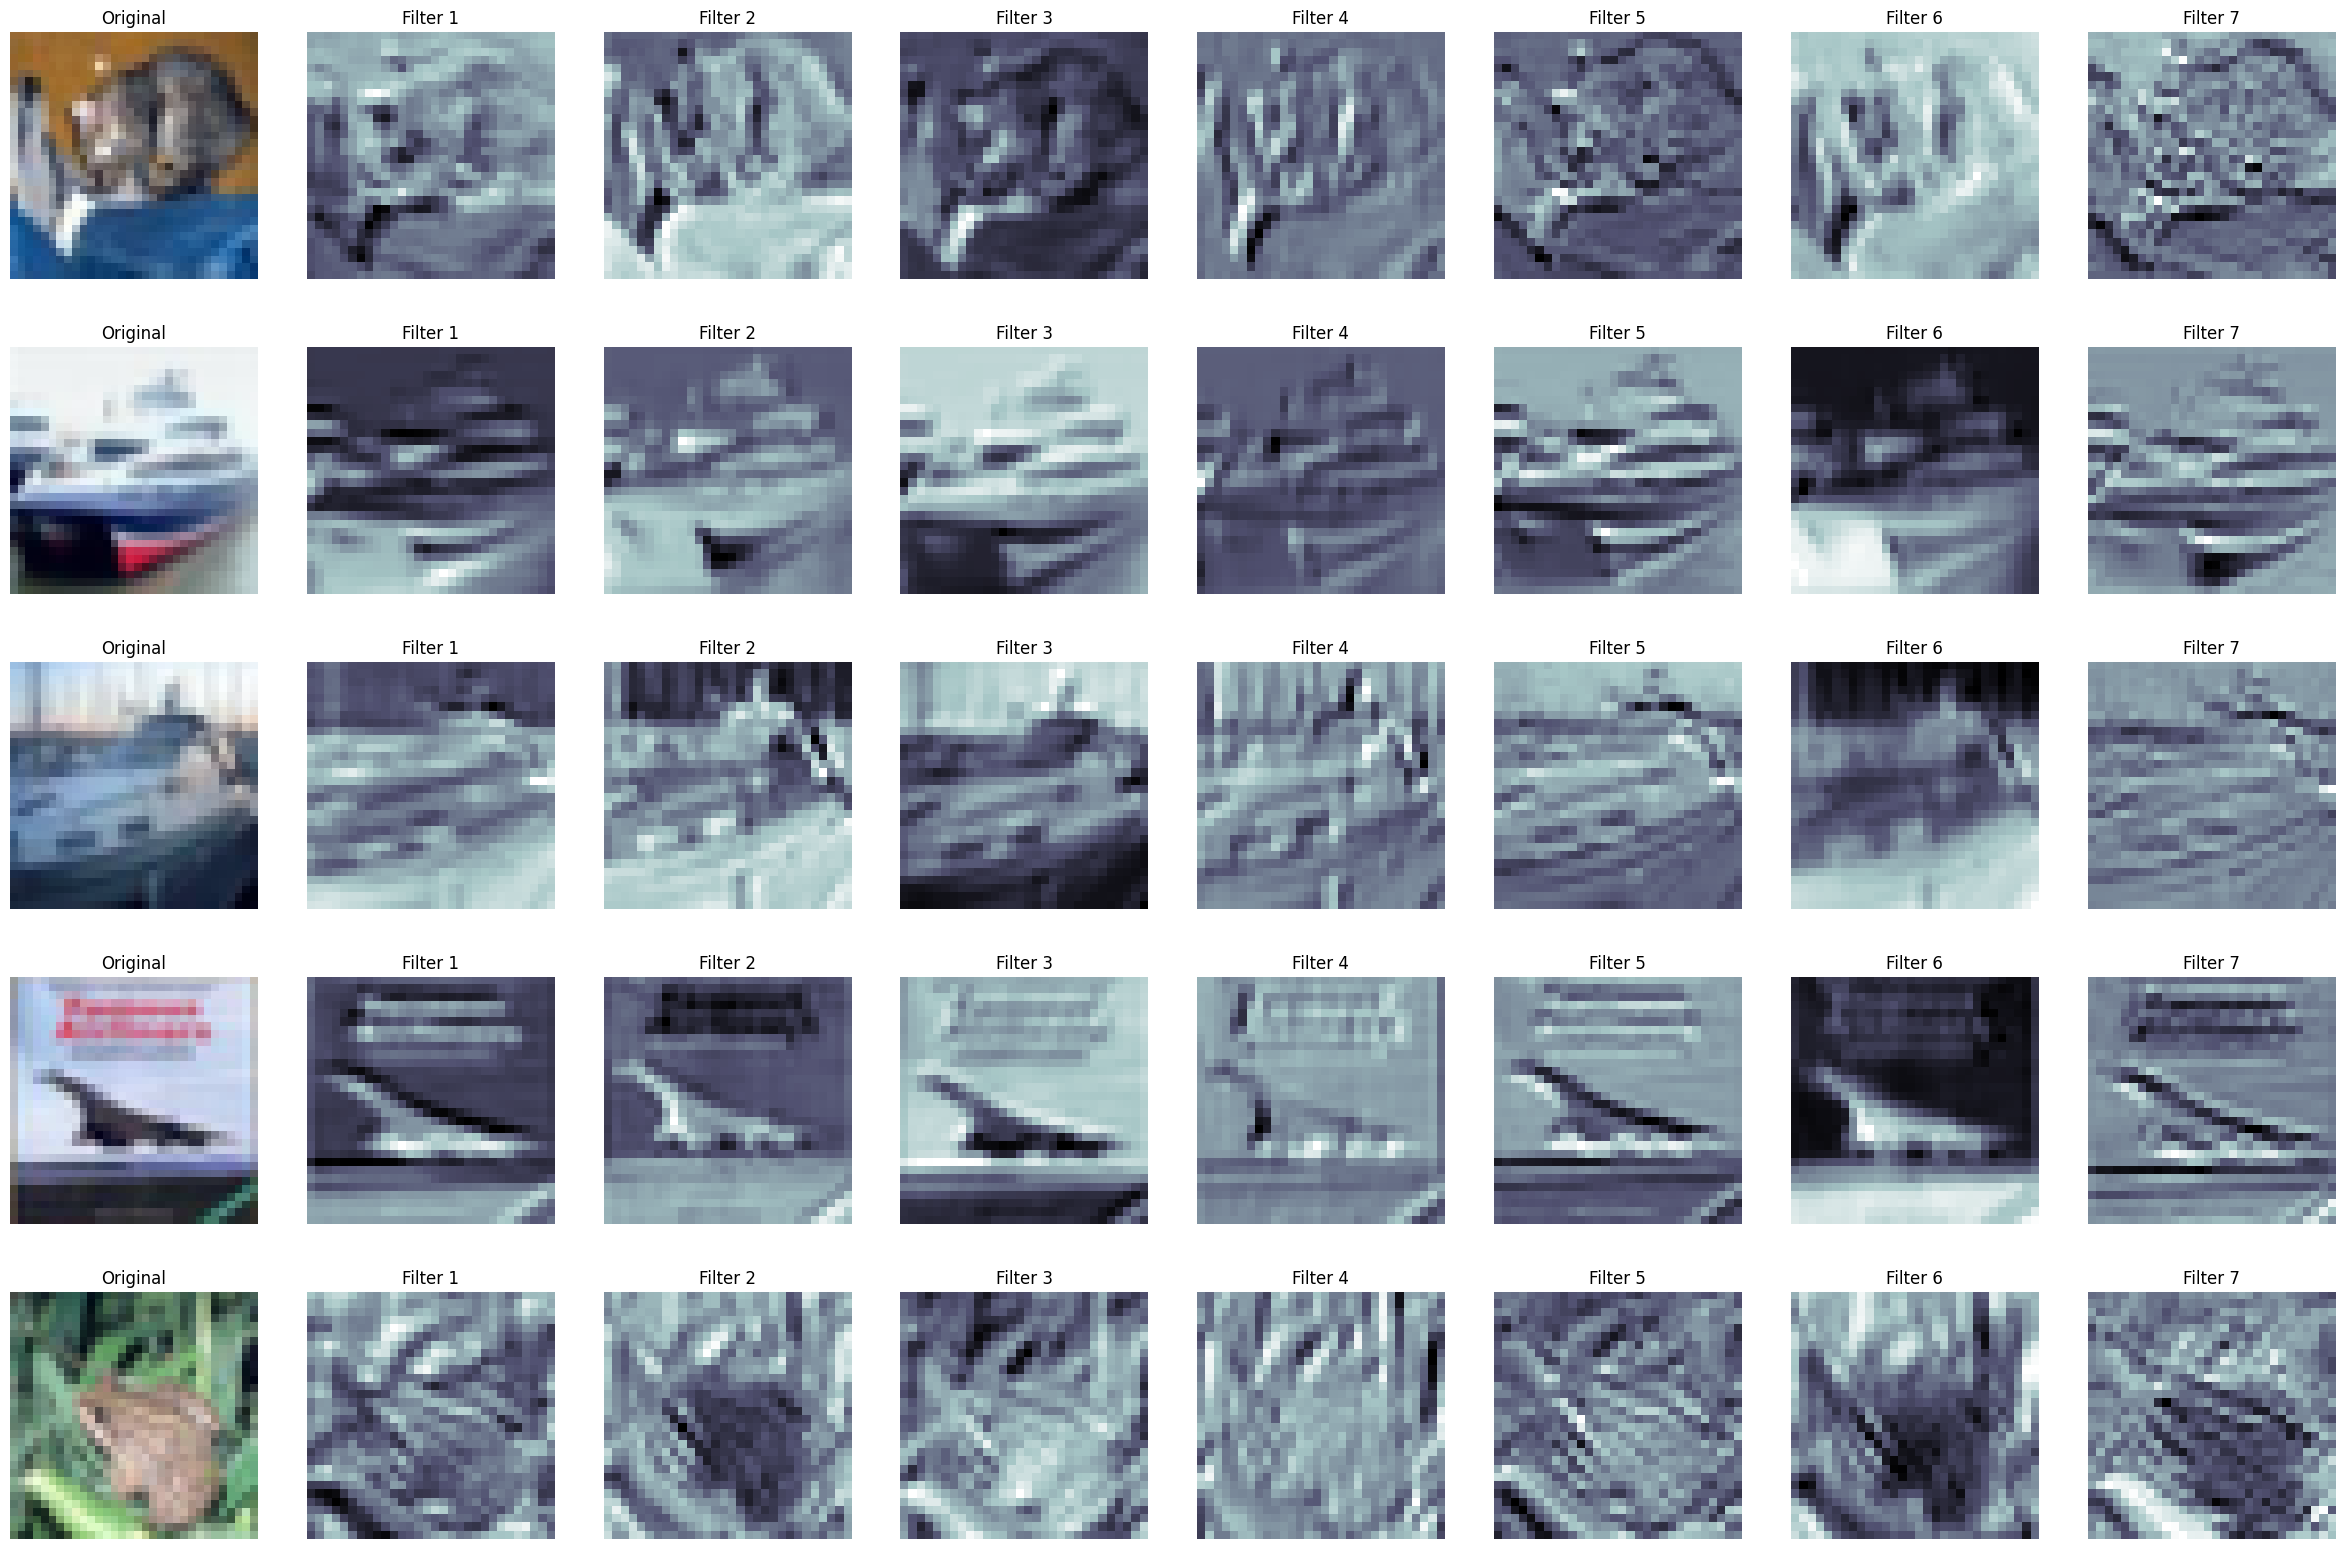

In [55]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

filters = model.features[0][0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [56]:
def plot_filters(filters, normalize=True):
    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):
        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Again, nothing really interpretable here, sadly.

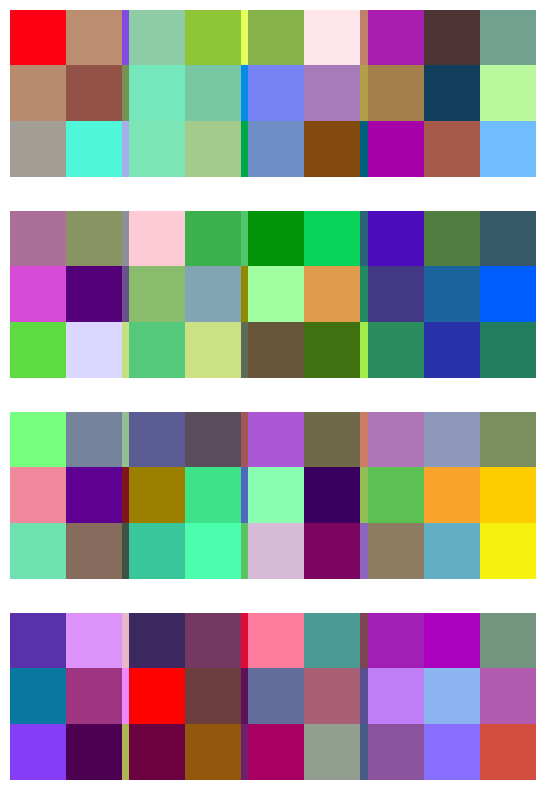

In [57]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (GooLeNet)
- custom weight initialization
- how to use the learning rate finder
- training a model to achieve >85% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake images
- viewing the learned weights of our model
- loading a pre-trained model

## Free GPU memory

In [ ]:
import os
 
pid = os.getpid()
!kill -9 $pid

# End